# Data set Description

This data set contains a set of bed-posture data, which were recollected in the paper: __[A Pressure Map Data set for In-bed Posture Classification](https://physionet.org/content/pmd/1.0.0/)__. There are a total of 13 individuals. For each one, a record have been done using a sensor. This sensor measured the pressure in a 32 * 64 mat. Also, the total record time per each individual was set to 2 minutes. The sensor recorded a total of 17 positions. These positions are: _supine, left, right, and fetus (right, left)_.

## Download the data set

First, we will download the data set.

In [1]:
!wget https://physionet.org/static/published-projects/pmd/a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
!unzip -q a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
!mv a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0 dataset 

--2019-08-13 16:26:24--  https://physionet.org/static/published-projects/pmd/a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
wget: /home/antonio/.netrc:4: unknown token "method"
wget: /home/antonio/.netrc:4: unknown token "interactive"
Resolving physionet.org (physionet.org)... 128.30.30.88
Connecting to physionet.org (physionet.org)|128.30.30.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107315828 (102M) [application/zip]
Saving to: ‘a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip.2’

a-pressure-map-data 100%[===================>] 102.34M  2.64MB/s    in 39s     

2019-08-13 16:27:04 (2.62 MB/s) - ‘a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip.2’ saved [107315828/107315828]

mv: cannot move 'a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0' to 'dataset/a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0': Directory not empty


We now have a folder called __dataset__, which contains two experiments. In the following sections, we will focus on experiment I.

# Libraries

In [1]:
import numpy as np
import os
from itertools import islice
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# Functions

In [38]:
def plot_losses(train_losses, test_losses, n_epochs):
    import seaborn as sns
    sns.set()
    plt.plot(range(n_epochs), train_losses)
    plt.plot(range(n_epochs), test_losses)
    plt.title('Train vs Test loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(['train', 'test'])
    plt.show()

In [4]:
def read_data(user):
    # data
    # get the total size
    size = [0]
    for file in range(1, 18):
        with open(path + user + "/" + str(file) + ".txt") as f:
            size.append(sum(1 for _ in f))
    # data
    data = np.empty((sum(size), 2048))
    # loop over the users
    for file in range(1, 18):
        # get the size of the study
        array = np.loadtxt(path + user + '/' + str(file) + '.txt')
        # assing data
        data[size[file - 1] :(size[file - 1] + size[file]), :] = array
    # replace nan values
    data[np.isnan(data)] = np.random.randn(len(data[np.isnan(data)]))
    # delete two first rows
    data = np.delete(data, (0, 1), axis=0)
    return data

In [5]:
def read_data_plot(user):
    # data
    data = np.empty((17, 2048))
    # loop over the users
    for file in range(1, 18):
        # get the size of the study
        with open(path + user + "/" + str(file) + ".txt") as f:
            size = sum(1 for _ in f)

        sample = int(np.random.choice(range(2, size), 1, replace = False))

        # read the 
        with open(path + user + "/" + str(file) + ".txt") as lines:
            array = np.genfromtxt(islice(lines, sample, sample + 1))
        data[file -1, :] = array
    return data

def plot_data(user):
    # first two recordings are the initial positions, therefore,
    # we will ignore them.
    # read the user
    data = read_data_plot(user)
    w, h = data.shape
    f, arr = plt.subplots(2, 8, figsize = (15, 5))
    f.suptitle('Position data for user: {}'.format(user))
    fig = 0
    for r in range(2):
        for c in range(8):
            arr[r, c].imshow(data[fig, :].reshape(64, 32), aspect = 'auto')
            arr[r, c].axis('off')
            fig += 1

In [6]:
def create_numpy_data(path):
    """
    Creates a numpy array for the data and labels.
    
    params:
    ------
    path    -- Data path.
    
    returns:
    -------
    A numpy array (data, labels).
    """
    subjects_dict = {}
    positions = ["justAPlaceholder","supine", "right", "left", "right", "right", "left", "left", 
                 "supine", "supine", "supine", "supine", "supine", "right", "left", "supine", "supine", 
                 "supine"]
    for _, dirs, _ in os.walk(path):
        for directory in dirs:
            # each directory is a subject
            subject = directory
            data = None
            labels = None
            for _, _, files in os.walk(os.path.join(path, directory)):
                for file in files:
                    file_path = os.path.join(path, directory, file)
                    with open(file_path, 'r') as f:
                        # Start from second recording, as the first two are corrupted
                        for line in f.read().splitlines()[2:]:
                            def token_position(x):
                                return {
                                    'supine': 0,
                                    'left': 1,
                                    'right': 2,
                                    'left_fetus': 3,
                                    'right_fetus': 4
                                }[x]
                            raw_data = np.fromstring(line, dtype=float, sep='\t').reshape(1,64,32)
                            file_data = np.round(raw_data*255/1000).astype(np.uint8) # Change the range from [0-1000] to [0-255]. This allows us to use tranforms later.
                            file_label = token_position(positions[int(file[:-4])]) # Turn the file index into position list, and turn position list into reduced indices.
                            file_label = np.array([file_label])

                            if data is None:
                                data = file_data
                            else:
                                data = np.concatenate((data, file_data), axis=0)
                            if labels is None:
                                labels = file_label
                            else:
                                labels = np.concatenate((labels, file_label), axis=0)

            subjects_dict[subject] = (data, labels)
    # create a single data set
    users = list(subjects_dict.keys())
    # assing data
    data = subjects_dict[users[0]][0]
    labels = subjects_dict[users[0]][1]
    # loop over the users
    for user in users[1:]:
        data = np.append(data, subjects_dict[user][0], axis = 0)
        labels = np.append(labels, subjects_dict[user][1], axis = 0)
        
    return data.reshape(-1, 2048), labels

In [25]:
def train_model(model, loaders, model_optimizer, criterion, n_epochs, print_epoch=True):
    """
    This function train the model.
    """
    model.train()
    running_loss = 0
    train_losses, test_losses = [], []
    for epoch in range(n_epochs):
        for data, labels in loaders[0]:
            model_optimizer.zero_grad()
            # get predictions
            y_hat = model(data)
            # calculate loss
            loss = criterion(y_hat, labels)
            loss.backward()
            # optimize
            model_optimizer.step()
            # show loss
            running_loss += loss.data.numpy()
        else:
            test_loss = 0
            accuracy = 0
            model.eval()
            
            with torch.no_grad():
                for inputs, labels in loaders[1]:
                    logps = model(inputs)
                    loss = criterion(logps, labels)
                    test_loss += loss.data.numpy()
        
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.float())
    
            train_losses.append(running_loss/len(loaders[0]))
            test_losses.append(test_loss/len(loaders[1]))
            
        if print_epoch:
            print('Epoch: {}|{} | Training loss: {} | Test loss: {} | Test accuracy: {}'.format(epoch + 1, n_epochs, 
                                                                                                running_loss/len(loaders[0]),
                                                                                               test_loss/len(loaders[1]),
                                                                                                accuracy/len(loaders[1])))
        running_loss = 0
        model.train()
    return model, train_losses, test_losses

# Exploratory Analysis

In [8]:
# set path
path = './dataset/experiment-i/'

In this dataset we have a total of 13 users. For each user a total of 17 txt files contain their bed positions.

In [9]:
# read users
users = users = os.listdir(path)
# remove cvs file
users = users[1:]

In [10]:
# print users
for u in users:
    print(u, end = ' ')

S7 S3 S6 S10 S8 S13 S5 S12 S9 S11 S1 S4 S2 

As we can see, we have a total of 13 inviduals in the data set. Now, we will explore the data. In particular, since we have a total of 13 inviduals, we will explore each one.

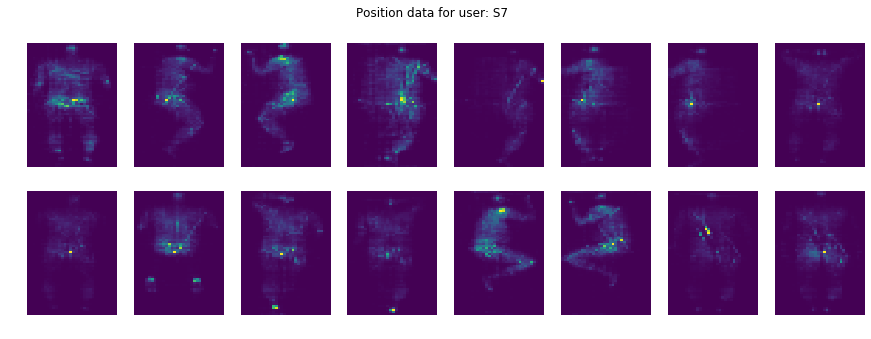

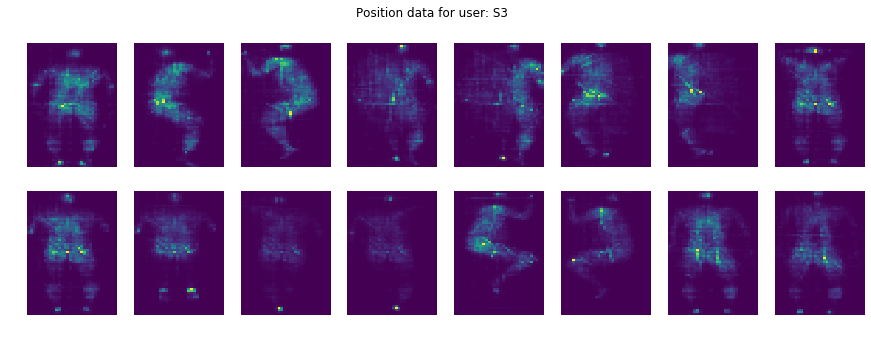

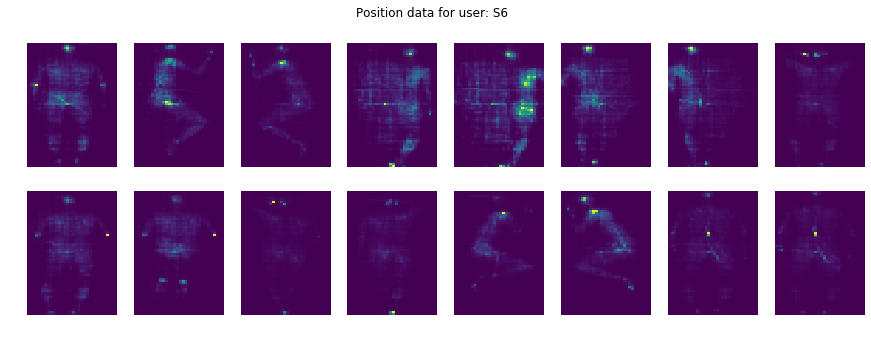

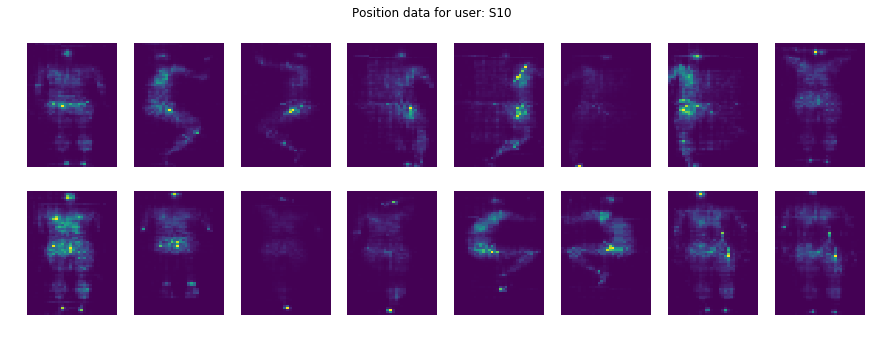

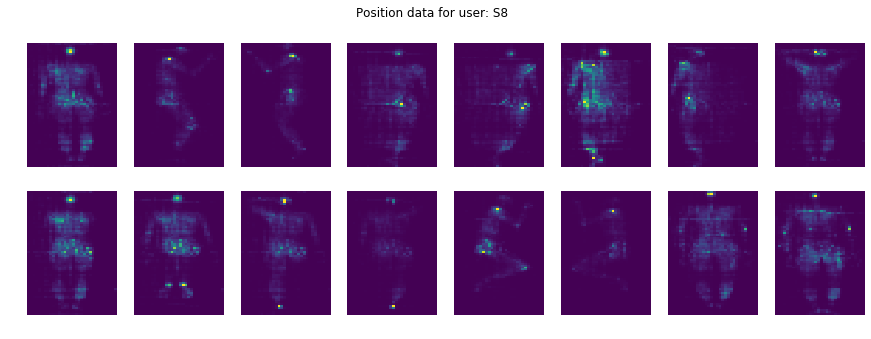

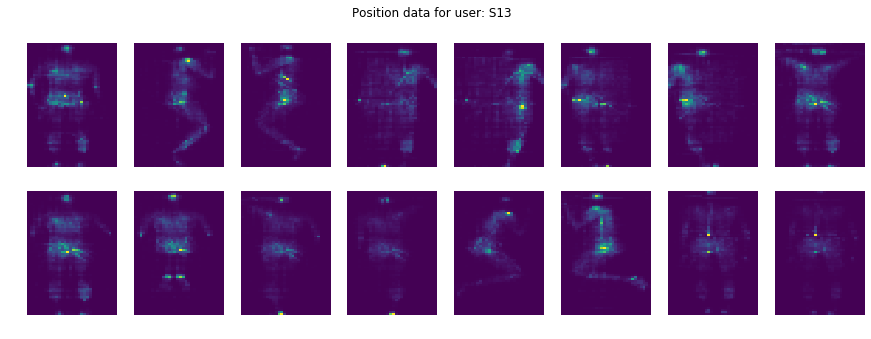

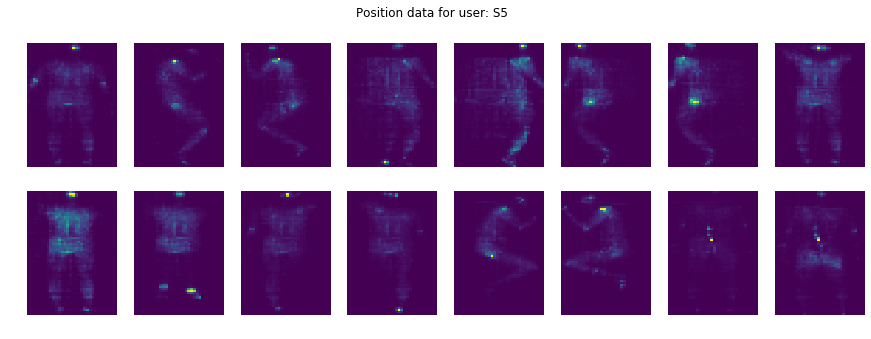

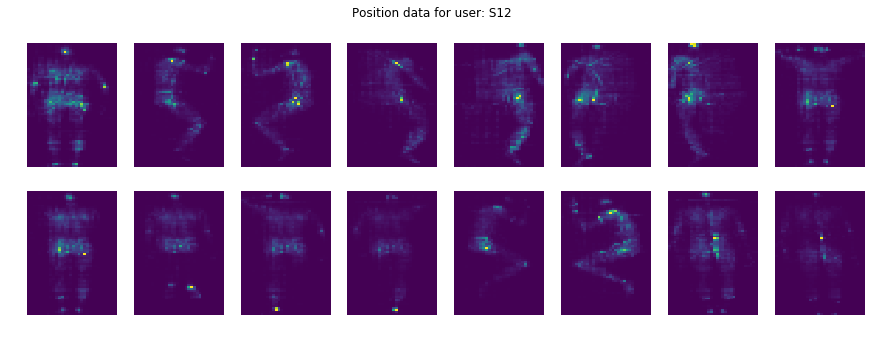

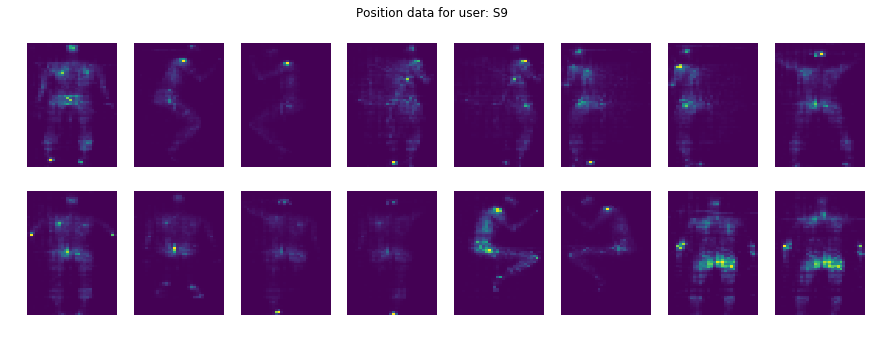

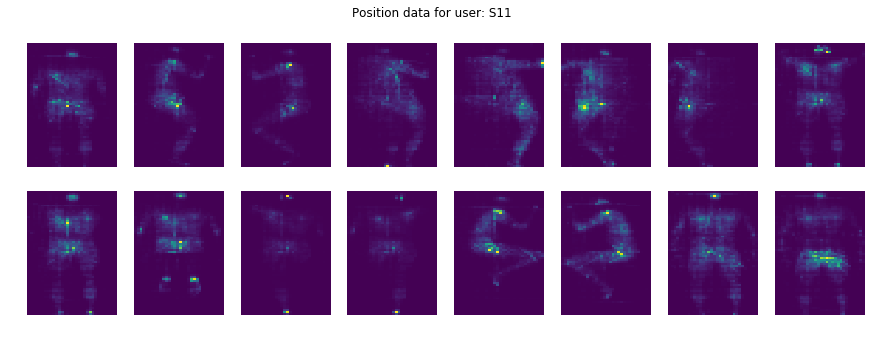

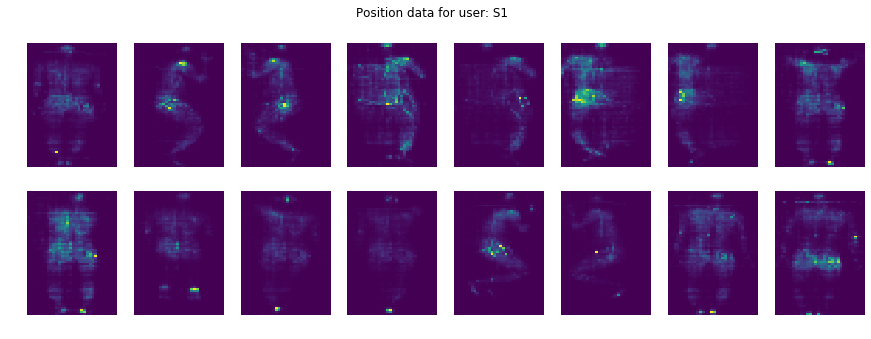

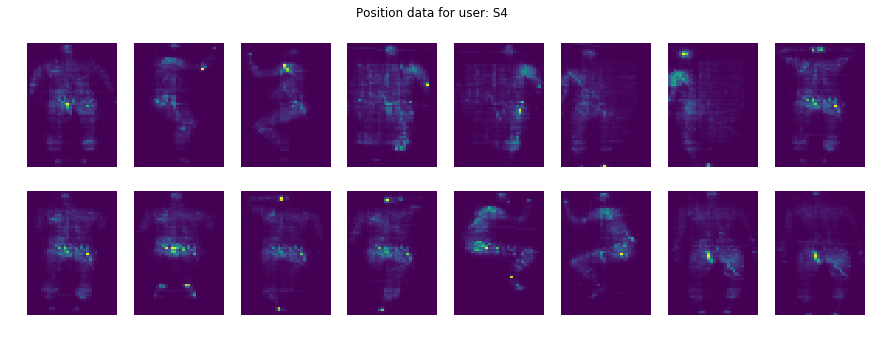

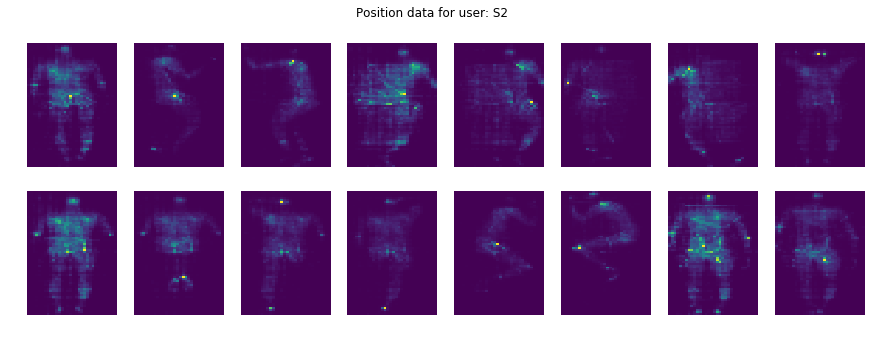

In [11]:
for user in users:
    plot_data(user)

After observing the data, it seems that some samples have a degree of noise. This could be due to diverse factors. Also, we can see that for each individual, we have a set of positions, which were recorded using a sensor. In the following sections, we will implement a shallow model to learn from this data.

# Training a Shallow Model

## Loading the data

In [11]:
data, labels = create_numpy_data(path)

In [12]:
# set training percentage
train_percent = 0.8
train_size = int(train_percent * data.shape[0])

In [13]:
# generate train - test splits
dataset_size = data.shape[0]
indices = list(range(dataset_size))
split = train_size
train_indices, test_indices = indices[:split], indices[split:]

In [14]:
# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
# convert to tensor
dataset = torch.utils.data.TensorDataset(torch.from_numpy(data).float() , torch.from_numpy(labels).long())
# loaders, shuffle is set to false, since we are using SubsetRandomSampler
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle = False,
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle = False,
                                                sampler=test_sampler)

## Model

In [73]:
class ShallowNet(nn.Module):
    """
    Shallow model, composed by four layers.
    """
    def __init__(self, n_inputs):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, 150)
        self.fc2 = nn.Linear(150, 100)
        self.output = nn.Linear(100, 5)
        
    def forward(self, x):      
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p = 0.25)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p = 0.25)
        return F.log_softmax(self.output(x), dim = 1)

## Training

In [79]:
# instanciate model
model = ShallowNet(2048)
model

ShallowNet(
  (fc1): Linear(in_features=2048, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=5, bias=True)
)

In [80]:
# Set model hyper-parameters
model_optimizer=optim.SGD(model.parameters(),lr=0.0001)
# criterion
criterion = nn.NLLLoss()

In [81]:
# set data loaders
loaders = [train_loader, test_loader]

In [82]:
# training
n_epochs = 10
model, train_losses, test_losses = train_model(model, loaders, model_optimizer, criterion, n_epochs, print_epoch=True)

Epoch: 1|10 | Training loss: 0.7542146735653585 | Test loss: 0.6887041993679539 | Test accuracy: 0.7593633532524109
Epoch: 2|10 | Training loss: 0.2286077457423113 | Test loss: 0.5424700095768897 | Test accuracy: 0.8243834972381592
Epoch: 3|10 | Training loss: 0.13687584146249052 | Test loss: 0.4620742901198326 | Test accuracy: 0.8418114185333252
Epoch: 4|10 | Training loss: 0.09714519747970056 | Test loss: 0.41426872065471065 | Test accuracy: 0.8588709831237793
Epoch: 5|10 | Training loss: 0.07642982336787545 | Test loss: 0.4142551559113687 | Test accuracy: 0.872053325176239
Epoch: 6|10 | Training loss: 0.06337849468905099 | Test loss: 0.39682487398386 | Test accuracy: 0.8717819452285767
Epoch: 7|10 | Training loss: 0.05008338850979902 | Test loss: 0.3797006506112314 | Test accuracy: 0.8806024789810181
Epoch: 8|10 | Training loss: 0.04576045759022236 | Test loss: 0.36137823075536757 | Test accuracy: 0.8868641257286072
Epoch: 9|10 | Training loss: 0.03926155190838843 | Test loss: 0.359

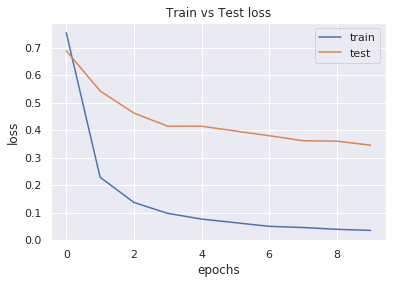

In [84]:
plot_losses(train_losses, test_losses, n_epochs)

## Conclusions
In this notebook, we have perform a basic EDA over the data set. Also, we have trained a shallow model. The model achieve a good accuracy. However, since we are dealing with images, a convolutional model could perform better. Since this model needs more time to train.